In [ ]:
import os
import numpy as np
import trimesh
from scipy.ndimage import zoom

def stl_to_voxel(filepath, resolution=32):
    mesh = trimesh.load_mesh(filepath)


    mesh.apply_translation(-mesh.bounding_box.centroid)
    scale = 1.0 / max(mesh.extents)
    mesh.apply_scale(scale)


    voxel_grid = mesh.voxelized(pitch=1.0 / resolution)
    matrix = voxel_grid.matrix.astype(np.uint8)


    matrix_resized = zoom(matrix,
                          (resolution / matrix.shape[0],
                           resolution / matrix.shape[1],
                           resolution / matrix.shape[2]),
                          order=0)  # 0 = nearest-neighbor
    return matrix_resized


input_folder = r"C:\Users\golds\Desktop\Data-Driven Design\converted_stl"
output_folder = r"C:\Users\golds\Desktop\Data-Driven Design\voxel_output"
os.makedirs(output_folder, exist_ok=True)


for fname in os.listdir(input_folder):
    if fname.lower().endswith(".stl"):
        fpath = os.path.join(input_folder, fname)
        try:
            vox = stl_to_voxel(fpath, resolution=32)
            np.save(os.path.join(output_folder, fname.replace(".stl", ".npy")), vox)
            print(f"✅ Saved: {fname}")
        except Exception as e:
            print(f"❌ Error with {fname}: {e}")


✅ Saved: bracelet_0_scene.stl
✅ Saved: bracelet_12_scene.stl
✅ Saved: bracelet_13_scene.stl
✅ Saved: bracelet_14_scene.stl
✅ Saved: bracelet_1_scene.stl
✅ Saved: bracelet_2_scene.stl
✅ Saved: bracelet_3_scene.stl
✅ Saved: bracelet_6_scene.stl
✅ Saved: bracelet_7_scene.stl
✅ Saved: bracelet_8_scene.stl
✅ Saved: bracelet_9_scene.stl
✅ Saved: earrings_13_scene.stl
✅ Saved: earrings_16_scene.stl
✅ Saved: earrings_17_scene.stl
✅ Saved: earrings_19_scene.stl
✅ Saved: earrings_1_scene.stl
✅ Saved: earrings_20_scene.stl
✅ Saved: earrings_21_scene.stl
✅ Saved: earrings_22_scene.stl
✅ Saved: earrings_23_scene.stl
✅ Saved: earrings_2_scene.stl
✅ Saved: earrings_3_scene.stl
✅ Saved: earrings_4_scene.stl
✅ Saved: earrings_5_scene.stl
✅ Saved: earrings_7_scene.stl
✅ Saved: earrings_8_scene.stl
✅ Saved: earrings_9_scene.stl
✅ Saved: necklace_10_scene.stl
✅ Saved: necklace_11_scene.stl
✅ Saved: necklace_14_scene.stl
✅ Saved: necklace_1_scene.stl
✅ Saved: necklace_2_scene.stl
✅ Saved: necklace_3_scene.

In [ ]:
import numpy as np
import os

folder_path = r"C:\Users\golds\Desktop\Data-Driven Design\voxel_output"

voxel_dataset = []
expected_shape = (32, 32, 32)  # 你希望所有体素网格统一为这个形状

for filename in os.listdir(folder_path):
    if filename.endswith(".npy"):
        filepath = os.path.join(folder_path, filename)
        voxel = np.load(filepath)

        # 检查维度是否正确
        if voxel.shape == expected_shape:
            voxel_dataset.append(voxel)
        else:
            print(f"❌ 跳过：{filename} 的形状为 {voxel.shape}")

# 转为 numpy array
voxel_dataset = np.stack(voxel_dataset)  # 用 stack 代替 array 更安全

# 保存为合并后的体素数据文件
np.save(os.path.join(folder_path, "voxel_dataset_combined.npy"), voxel_dataset)

print("✅ 成功加载体素数据，形状为：", voxel_dataset.shape)


❌ 跳过：voxel_dataset_combined.npy 的形状为 (49, 32, 32, 32)
✅ 成功加载体素数据，形状为： (49, 32, 32, 32)


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class VoxelDataset(Dataset):
    def __init__(self, npy_path):
        self.data = np.load(npy_path)
        self.data = self.data.astype(np.float32)  # 转 float32
        self.data = np.expand_dims(self.data, axis=1)  # (N, 1, 32, 32, 32) for CNN
        self.data = self.data / self.data.max()  # 归一化为 0~1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 加载数据
dataset = VoxelDataset(r"C:\Users\golds\Desktop\Data-Driven Design\voxel_dataset_combined.npy")
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看尺寸
for vox in dataloader:
    print("✅ Batch shape:", vox.shape)  # (8, 1, 32, 32, 32)
    break


✅ Batch shape: torch.Size([8, 1, 32, 32, 32])


In [16]:
import torch
import torch.nn as nn

# 3D DCGAN Generator
class Generator3D(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator3D, self).__init__()
        self.model = nn.Sequential(
            # input Z: (N, 100, 1, 1, 1)
            nn.ConvTranspose3d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm3d(512),
            nn.ReLU(True),
            # (N, 512, 4, 4, 4)
            nn.ConvTranspose3d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            # (N, 256, 8, 8, 8)
            nn.ConvTranspose3d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            # (N, 128, 16, 16, 16)
            nn.ConvTranspose3d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(True),
            # (N, 64, 32, 32, 32)
            nn.ConvTranspose3d(64, 1, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 3D DCGAN Discriminator
class Discriminator3D(nn.Module):
    def __init__(self):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            # input: (N, 1, 32, 32, 32)
            nn.Conv3d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (N, 64, 16, 16, 16)
            nn.Conv3d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # (N, 128, 8, 8, 8)
            nn.Conv3d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # (N, 256, 4, 4, 4)
            nn.Conv3d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output: real/fake score
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

# Instantiate models
latent_dim = 100
generator = Generator3D(latent_dim)
discriminator = Discriminator3D()

generator, discriminator


(Generator3D(
   (model): Sequential(
     (0): ConvTranspose3d(100, 512, kernel_size=(4, 4, 4), stride=(1, 1, 1), bias=False)
     (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
     (4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
     (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
     (9): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
     (10): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): ReLU(inplace=True)
     (12): ConvTranspose3d(64, 1, kernel_size=(3, 3, 3), stride=(1, 1

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os

# 假设你已经生成了 voxel_dataset_combined.npy 并且文件路径如下：
npy_path = r"C:\Users\golds\Desktop\Data-Driven Design\voxel_dataset_combined.npy"

# 加载数据
voxel_dataset_combined = np.load(npy_path)
voxel_tensor = torch.tensor(voxel_dataset_combined, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 32, 32, 32)

# 构建 DataLoader
dataset = TensorDataset(voxel_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 定义 Generator 和 Discriminator
class Generator3D(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator3D, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose3d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm3d(512),
            nn.ReLU(True),

            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(256),
            nn.ReLU(True),

            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(128),
            nn.ReLU(True),

            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(True),

            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator3D(nn.Module):
    def __init__(self):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator3D().to(device)
D = Discriminator3D().to(device)

# 损失函数与优化器
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 训练参数
latent_dim = 100
epochs = 50

# 训练循环
for epoch in range(epochs):
    for i, (real_voxels,) in enumerate(dataloader):
        real_voxels = real_voxels.to(device)

        # 训练 Discriminator
        optimizer_D.zero_grad()
        batch_size = real_voxels.size(0)
        real_labels = torch.ones(batch_size, 1, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1, 1).to(device)

        outputs_real = D(real_voxels)
        d_loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1, 1).to(device)
        fake_voxels = G(z)
        outputs_fake = D(fake_voxels.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # 训练 Generator
        optimizer_G.zero_grad()
        outputs = D(fake_voxels)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# 保存模型
torch.save(G.state_dict(), "generator3d.pth")
torch.save(D.state_dict(), "discriminator3d.pth")


Epoch [1/50], D Loss: 0.0194, G Loss: 7.6543
Epoch [2/50], D Loss: 0.1606, G Loss: 8.2378
Epoch [3/50], D Loss: 0.1683, G Loss: 5.9265
Epoch [4/50], D Loss: 0.0019, G Loss: 7.6753
Epoch [5/50], D Loss: 0.5165, G Loss: 8.9684
Epoch [6/50], D Loss: 0.4026, G Loss: 6.9351
Epoch [7/50], D Loss: 0.8239, G Loss: 5.5268
Epoch [8/50], D Loss: 1.5934, G Loss: 3.2162
Epoch [9/50], D Loss: 0.3128, G Loss: 4.7200
Epoch [10/50], D Loss: 3.1692, G Loss: 10.8299
Epoch [11/50], D Loss: 0.3931, G Loss: 3.4236
Epoch [12/50], D Loss: 0.6703, G Loss: 7.2426
Epoch [13/50], D Loss: 1.0416, G Loss: 9.0031
Epoch [14/50], D Loss: 0.0848, G Loss: 4.6904
Epoch [15/50], D Loss: 0.1571, G Loss: 6.5190
Epoch [16/50], D Loss: 0.0344, G Loss: 6.1860
Epoch [17/50], D Loss: 0.5083, G Loss: 8.5425
Epoch [18/50], D Loss: 0.1978, G Loss: 7.7510
Epoch [19/50], D Loss: 0.0119, G Loss: 5.3388
Epoch [20/50], D Loss: 0.6017, G Loss: 13.6137
Epoch [21/50], D Loss: 1.2760, G Loss: 20.3142
Epoch [22/50], D Loss: 0.4504, G Loss: 6

✅ saved: generated_voxel_0.npy
✅ saved: generated_voxel_1.npy
✅ saved: generated_voxel_2.npy
✅ saved: generated_voxel_3.npy
✅ saved: generated_voxel_4.npy
✅ saved: generated_voxel_5.npy
✅ saved: generated_voxel_6.npy
✅ saved: generated_voxel_7.npy
✅ saved: generated_voxel_8.npy
✅ saved: generated_voxel_9.npy
✅ saved: generated_voxel_10.npy
✅ saved: generated_voxel_11.npy
✅ saved: generated_voxel_12.npy
✅ saved: generated_voxel_13.npy
✅ saved: generated_voxel_14.npy
✅ saved: generated_voxel_15.npy
✅ saved: generated_voxel_16.npy
✅ saved: generated_voxel_17.npy
✅ saved: generated_voxel_18.npy
✅ saved: generated_voxel_19.npy
✅ saved: generated_voxel_20.npy
✅ saved: generated_voxel_21.npy
✅ saved: generated_voxel_22.npy
✅ saved: generated_voxel_23.npy
✅ saved: generated_voxel_24.npy
✅ saved: generated_voxel_25.npy
✅ saved: generated_voxel_26.npy
✅ saved: generated_voxel_27.npy
✅ saved: generated_voxel_28.npy
✅ saved: generated_voxel_29.npy
✅ saved: generated_voxel_30.npy
✅ saved: generated

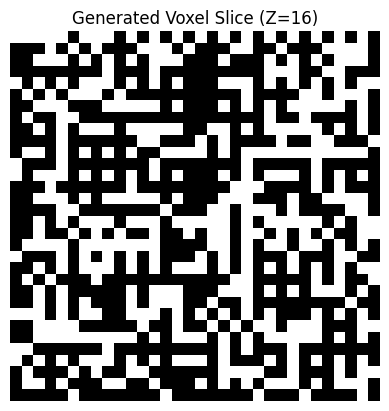

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)  # ✅ 移动模型到 GPU

# 设置为评估模式
generator.eval()

# 生成 n 个体素模型
n = 50
with torch.no_grad():
    noise = torch.randn(n, 100, 1, 1, 1).to(device)  # 随机噪声
    fake_voxels = generator(noise).cpu().numpy()     # 回到 CPU
    fake_voxels = (fake_voxels > 0.5).astype(np.uint8)  # 二值化

# 保存为 .npy 文件
for i in range(n):
    np.save(f"generated_voxel_{i}.npy", fake_voxels[i, 0])
    print(f"✅ saved: generated_voxel_{i}.npy")

# 可视化其中一个切片
plt.imshow(fake_voxels[0, 0, 16, :, :], cmap="gray")  # 使用灰度图显示
plt.title("Generated Voxel Slice (Z=16)")
plt.axis("off")
plt.show()


In [26]:
import os
import numpy as np
import trimesh
from skimage import measure

def voxel_to_stl(voxel_grid, output_path):
    """
    将体素 numpy 数组转换为 STL 网格文件
    """
    voxel_grid = voxel_grid.squeeze()  # 去除多余维度 (1, 32, 32, 32) -> (32, 32, 32)
    if voxel_grid.ndim != 3:
        raise ValueError(f"Unexpected voxel shape: {voxel_grid.shape}")

    verts, faces, _, _ = measure.marching_cubes(voxel_grid, level=0.5)
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    mesh.export(output_path)
    print(f"✅ Exported: {output_path}")

def batch_convert_npy_to_stl(folder_path):
    """
    遍历文件夹，将每个 .npy 文件转换为 .stl
    """
    output_folder = os.path.join(folder_path, "stl_output")
    os.makedirs(output_folder, exist_ok=True)

    npy_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

    if not npy_files:
        print("❌ No .npy files found.")
        return

    for fname in npy_files:
        fpath = os.path.join(folder_path, fname)
        voxel = np.load(fpath)

        stl_name = os.path.splitext(fname)[0] + ".stl"
        output_path = os.path.join(output_folder, stl_name)

        try:
            voxel_to_stl(voxel, output_path)
        except Exception as e:
            print(f"⚠️ Failed on {fname}: {e}")

# ✅ 修改为你自己的路径：
folder_path = r"C:\Users\golds\Desktop\Data-Driven Design\generated_voxel"
batch_convert_npy_to_stl(folder_path)


✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_0.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_1.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_10.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_11.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_12.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_13.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_14.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_15.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_voxel\stl_output\generated_voxel_16.stl
✅ Exported: C:\Users\golds\Desktop\Data-Driven Design\generated_vo